<a href="https://colab.research.google.com/github/ranganpal/Heart-Attack-ECG-Detection/blob/main/heart_attack_ecg_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ❤️ Myocardial Infarction (MI) Detection from 12-Lead ECG (PTB-XL Dataset)

This notebook implements an automated framework for classifying ECG signals using **classical Machine Learning** and **Deep Learning** techniques.

We compare two distinct approaches for **Binary Classification** (Normal vs. Abnormal):
1.  **Feature-Based Approach (ML):** Extracting morphological features using Median Beats and PCA, classified via Logistic Regression and Random Forest.
2.  **End-to-End Approach (DL):** Using Raw Signal data fed directly into a 1D Convolutional Neural Network (CNN).

### 🔹 Key Methodologies
* **Dataset:** PTB-XL (500 Hz), utilizing **all 12 Leads**.
* **Preprocessing:** Bandpass filtering (0.5-50 Hz) & R-Peak detection on Lead II.
* **Feature Engineering (Phase 2):**
    * **Median Beat Construction:** Robust "Territory Logic" (dynamic windowing) to handle Tachycardia/Bradycardia.
    * **Dimensionality Reduction:** Universal PCA to extract **60 standardized features** (5 components per lead).
* **Models:**
    * **Logistic Regression:** Baseline linear classifier on PCA features.
    * **Random Forest:** Non-linear ensemble classifier on PCA features.
    * **1D-CNN:** Deep learning model trained on **Raw 12-lead Time-Series** (5000 samples).

### 🔹 Goal
To evaluate if engineered morphological features (PCA) can compete with the raw signal learning capabilities of Convolutional Neural Networks for detecting cardiac abnormalities.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pip install wfdb --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.7 MB/s eta 0:00:00


In [50]:
import os, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import joblib
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

DATASET_PATH = "/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
META_FILE_PTB = os.path.join(DATASET_PATH, "ptbxl_database.csv")
META_FILE_SCP = os.path.join(DATASET_PATH, "scp_statements.csv")

SEED=42; LEAD_IDX=1; SAMPLE_RATE=500; TEST_SIZE=0.2; MAX_RECORDS=3000
WINDOW_LEN = 300; PRE_R = 100; POST_R = 200; SAFETY_MARGIN = 10

N_PCA_COMPONENTS = 5
CNN_EPOCHS=40; BATCH_SIZE=32

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

## Helper Functions

In [6]:
def safe_eval_scp(scp_code):
    try: return eval(scp_code) if isinstance(scp_code, str) else scp_code
    except: return {}

def ensure_len(sig, expected):
    # sig shape: (time, leads) or (time,)
    length = len(sig)
    if length == expected:
        return sig

    if length > expected:
        return sig[:expected]

    # Padding logic for 2D (12 leads) or 1D (single lead)
    diff = expected - length
    if sig.ndim == 1:
        pad = np.zeros(diff)
        return np.concatenate([sig, pad])
    else:
        # Assume shape (time, leads), pad along axis 0 (time)
        leads = sig.shape[1]
        pad = np.zeros((diff, leads))
        return np.concatenate([sig, pad], axis=0)

def normalize_per_record(X):
    # X shape: (n_samples, signal_len, n_leads)
    # Mean and Std along the signal_len dimension (axis 1)
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True) + 1e-8
    return (X - m) / s

def print_result(res):
    print(f"\nModel: {res['model']}")
    print(f"Accuracy: {res['accuracy']:.2%}")
    print(f"Precision: {res['precision']:.2%}")
    print(f"Recall: {res['recall']:.2%}")
    print(f"F1 Score: {res['f1 score']:.2%}")

## Load Metadata

In [7]:
def load_metadata(max_records=MAX_RECORDS):
    # Load raw dataframes
    ptb_df = pd.read_csv(META_FILE_PTB)
    scp_df = pd.read_csv(META_FILE_SCP, index_col=0)

    # Convert scp_codes from string to dict
    ptb_df["scp_codes"] = ptb_df["scp_codes"].apply(safe_eval_scp)

    # Drop records without a filename
    ptb_df = ptb_df[ptb_df["filename_hr"].notna()].reset_index(drop=True)

    # --- Step 1: Build the Dictionary Map (Code -> Superclass) ---
    # We only keep codes that have a valid diagnostic_class (MI, STTC, CD, HYP, NORM)
    scp_df = scp_df[scp_df["diagnostic_class"].notna()]
    code_map = scp_df["diagnostic_class"].to_dict()

    # --- Step 2: Define the Labeling Function with Hierarchy ---
    def get_label(scp_dict):
        # Get all superclasses present for this patient
        classes = set()
        for code in scp_dict.keys():
            if code in code_map:
                classes.add(code_map[code])

        # Check Priority: MI > STTC > CD > HYP > NORM
        if "MI" in classes: return 1      # MI
        if "STTC" in classes: return 2    # STTC
        if "CD" in classes: return 3      # CD
        if "HYP" in classes: return 4     # HYP
        if "NORM" in classes: return 0    # NORM

        return -1 # Unknown/Other (will be dropped)

    # --- Step 3: Apply Labels ---
    ptb_df["label_multiclass"] = ptb_df["scp_codes"].apply(get_label)

    # Drop "Other/Unknown" (-1)
    ptb_df = ptb_df[ptb_df["label_multiclass"] != -1].reset_index(drop=True)

    # Create Binary Label: 0=NORM, 1=Abnormal (MI, STTC, CD, HYP)
    ptb_df["label_binary"] = ptb_df["label_multiclass"].apply(lambda x: 0 if x == 0 else 1)

    # --- Step 4: Stratified Sampling (Optional) ---
    if max_records is not None and max_records < len(ptb_df):
        from sklearn.model_selection import train_test_split
        # Stratify by multiclass label to keep distribution balanced
        ptb_df, _ = train_test_split(
            ptb_df,
            train_size=max_records,
            stratify=ptb_df["label_multiclass"],
            random_state=SEED,
        )
        ptb_df = ptb_df.reset_index(drop=True)

    return ptb_df

ptb_df = load_metadata()
print("Total records used:", len(ptb_df))
print("\nMulticlass Counts (0=NORM, 1=MI, 2=STTC, 3=CD, 4=HYP):")
print(ptb_df["label_multiclass"].value_counts().sort_index())
print("\nBinary Counts (0=Normal, 1=Abnormal):")
print(ptb_df["label_binary"].value_counts())
ptb_df[["ecg_id", "scp_codes", "label_multiclass", "label_binary"]]

Total records used: 3000

Multiclass Counts (0=NORM, 1=MI, 2=STTC, 3=CD, 4=HYP):
label_multiclass
0    1272
1     768
2     547
3     338
4      75
Name: count, dtype: int64

Binary Counts (0=Normal, 1=Abnormal):
label_binary
1    1728
0    1272
Name: count, dtype: int64


,ecg_id,scp_codes,label_multiclass,label_binary
0,5181,"{'IRBBB': 100.0, 'SR': 0.0}",3,1
1,21559,"{'NORM': 100.0, 'SR': 0.0}",0,0
2,14982,"{'LVH': 100.0, 'ISC_': 100.0, 'IVCD': 100.0, '...",2,1
3,20719,"{'NORM': 80.0, 'SR': 0.0}",0,0
4,8546,"{'LAFB': 100.0, 'SR': 0.0}",3,1
...,...,...,...,...
2995,21535,"{'LVH': 50.0, 'ISC_': 100.0, 'AFIB': 0.0}",2,1
2996,9402,"{'IMI': 100.0, 'ASMI': 100.0, '1AVB': 100.0, '...",1,1
2997,17394,"{'LMI': 15.0, 'ASMI': 50.0, 'IRBBB': 100.0, 'A...",1,1
2998,18538,"{'ASMI': 100.0, 'LAFB': 100.0, 'ABQRS': 0.0, '...",1,1


## Load One Signal and Smoke Test

Showing first 1 records (12-Lead view)...


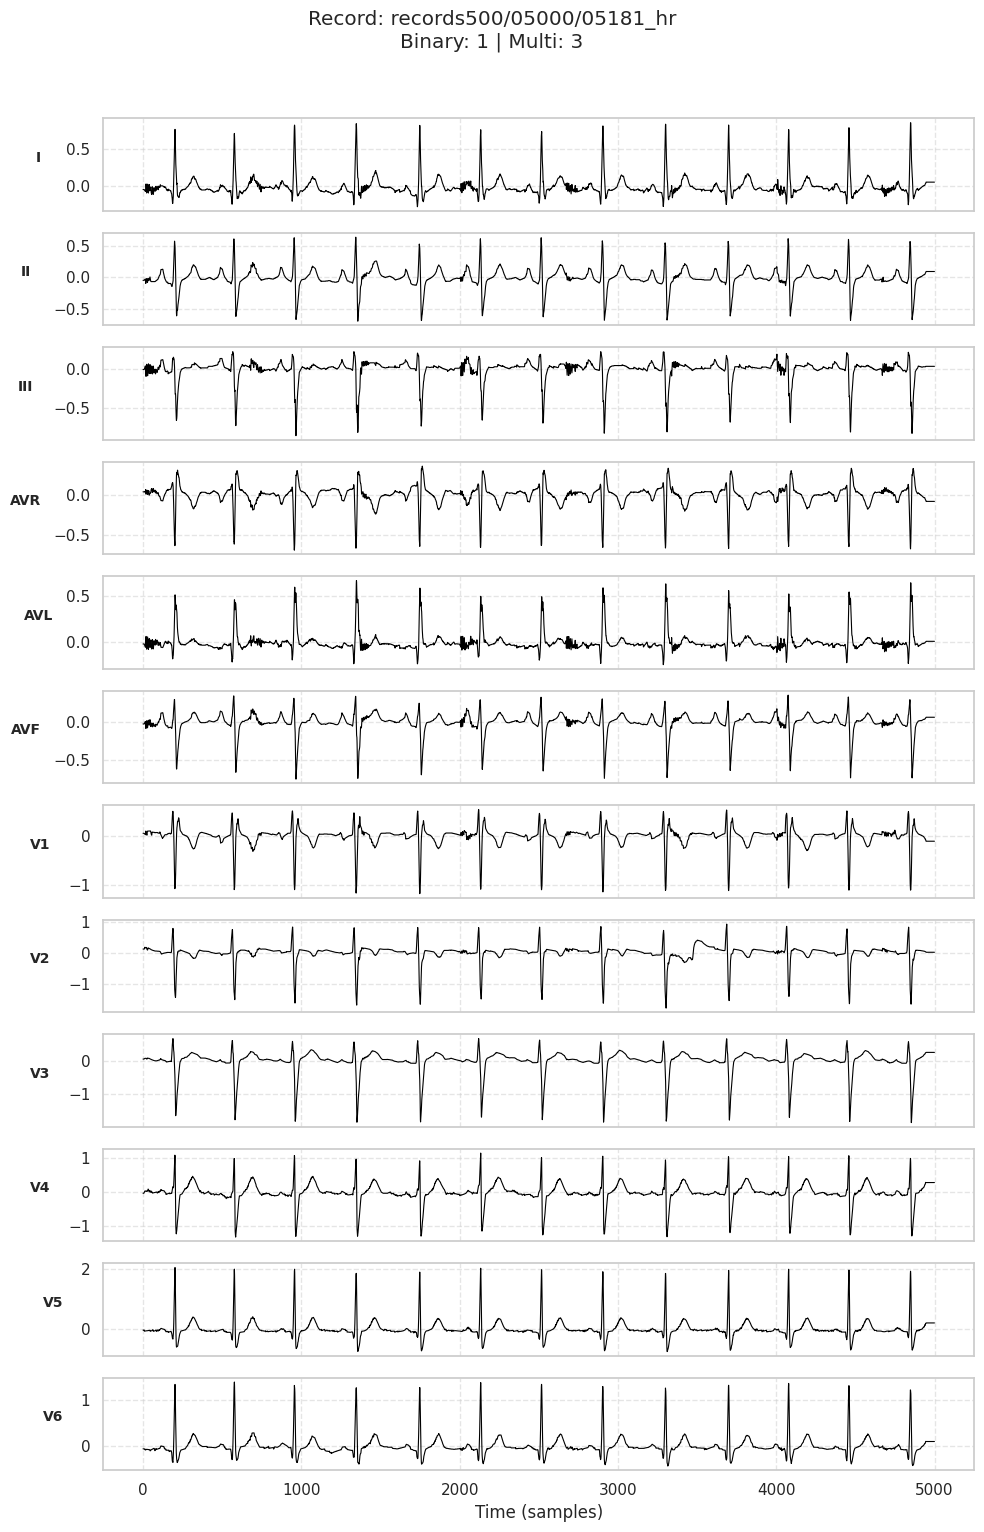

In [8]:
def load_signal_single(path_record):
    """
    Loads all 12 leads of the ECG signal.
    Returns: numpy array of shape (time_steps, 12)
    """
    try:
        recp = os.path.join(DATASET_PATH, path_record)
        # wfdb.rdsamp returns (signal, fields). We only need signal.
        sig, fields = wfdb.rdsamp(recp)
        return sig.astype(np.float32)
    except:
        return None

def smoke_test(df, count=1):
    print(f"Showing first {count} records (12-Lead view)...")

    lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    for row in df.itertuples():
        sig = load_signal_single(row.filename_hr)
        if sig is None:
            continue

        # Ensure length (now handles 12 leads)
        sig = ensure_len(sig, SAMPLE_RATE * 10)

        # Plot all 12 leads stacked
        fig, axes = plt.subplots(12, 1, figsize=(10, 15), sharex=True)

        for i in range(12):
            ax = axes[i]
            ax.plot(sig[:, i], color='black', linewidth=0.8)
            ax.set_ylabel(lead_names[i], rotation=0, labelpad=20, fontsize=10, fontweight='bold')
            ax.grid(True, linestyle='--', alpha=0.5)
            if i < 11:
                ax.tick_params(labelbottom=False)

        plt.suptitle(f"Record: {row.filename_hr}\nBinary: {row.label_binary} | Multi: {row.label_multiclass}", y=1.02)
        plt.xlabel("Time (samples)")
        plt.tight_layout()
        plt.show()

        count -= 1
        if count == 0:
            return

smoke_test(df=ptb_df)

## Build Raw Dataset

In [9]:
def build_raw_dataset(df):
    X, y_bin, y_multi, rec_ids = [], [], [], []

    for r in tqdm(df.itertuples(), desc="Loading ECG signals"):
        # Load the full 12-lead signal
        sig = load_signal_single(r.filename_hr)
        if sig is None:
            continue

        # Ensure length is exactly 5000 samples (handles 12 leads automatically)
        sig = ensure_len(sig, SAMPLE_RATE * 10)

        X.append(sig)
        y_bin.append(r.label_binary)
        y_multi.append(r.label_multiclass)
        rec_ids.append(r.filename_hr)

    # Stack to create 3D Array: (Samples, Time, Leads)
    X = np.stack(X)
    y_bin = np.array(y_bin)
    y_multi = np.array(y_multi)

    return X, y_bin, y_multi, rec_ids

# --- Execute the Build ---
X, y_bin, y_multi, rec_ids = build_raw_dataset(ptb_df)

# --- Normalize ---
X = normalize_per_record(X)

print("\nDataset Built!")
print("X shape:", X.shape)
print("y_bin shape:", y_bin.shape)
print("y_multi shape:", y_multi.shape)

Loading ECG signals: 3000it [30:32,  1.64it/s]



Dataset Built!
X shape: (3000, 5000, 12)
y_bin shape: (3000,)
y_multi shape: (3000,)


## Feature Extraction

In [17]:
def get_median_beats(sig):
    """
    Extracts the median beat from a 12-lead signal.
    Input: sig (5000, 12)
    Output: median_beat (12, 300) -> Transposed for PCA consistency
    """
    # 1. Detect Peaks on Lead II (Index 1)
    peaks, _ = find_peaks(sig[:, 1], distance=150, height=0.1)

    # If no peaks, return zeros (12 leads x 300 samples)
    if len(peaks) == 0:
        return np.zeros((12, WINDOW_LEN), dtype=np.float32)

    beats = []

    for i, r_curr in enumerate(peaks):
        # --- A. Define Ideal Territory ---
        ideal_start = r_curr - PRE_R
        ideal_end = r_curr + POST_R

        # --- B. Define Safety Limits ---
        if i > 0:
            limit_start = peaks[i-1] + POST_R + SAFETY_MARGIN
        else:
            limit_start = 0

        if i < len(peaks) - 1:
            limit_end = peaks[i+1] - PRE_R - SAFETY_MARGIN
        else:
            limit_end = sig.shape[0]

        # --- C. Truncate ---
        actual_start = max(ideal_start, limit_start)
        actual_end = min(ideal_end, limit_end)

        actual_start = max(0, actual_start)
        actual_end = min(sig.shape[0], actual_end)

        # --- D. The Canvas Method ---
        canvas = np.zeros((WINDOW_LEN, 12), dtype=np.float32)
        canvas_start_idx = PRE_R - (r_curr - actual_start)

        chunk = sig[actual_start:actual_end]
        chunk_len = len(chunk)

        if chunk_len == 0 or canvas_start_idx < 0 or (canvas_start_idx + chunk_len) > WINDOW_LEN:
            continue

        canvas[canvas_start_idx : canvas_start_idx + chunk_len] = chunk
        beats.append(canvas)

    # --- E. Compute Median ---
    if len(beats) == 0:
        return np.zeros((12, WINDOW_LEN), dtype=np.float32)

    beats = np.stack(beats) # Shape: (N_beats, 300, 12)
    median_beat = np.median(beats, axis=0) # Shape: (300, 12)

    # Transpose to return (12, 300)
    return median_beat.T

def train_pca_model(X):
    """
    Trains PCA on training set.
    Input: X (N, 5000, 12)
    Output: Trained PCA object
    """
    print("Preparing data for PCA training...")
    all_beats = []

    for x in tqdm(X, desc="Extracting Training Beats"):
        mb = get_median_beats(x) # Returns (12, 300)
        all_beats.append(mb)     # List of (12, 300) arrays

    # Stack: (N_patients * 12, 300)
    X_for_pca = np.vstack(all_beats)

    print(f"Training PCA on {X_for_pca.shape[0]} individual lead waveforms...")
    pca = PCA(n_components=N_PCA_COMPONENTS)
    pca.fit(X_for_pca)

    print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.2%}")
    return pca

def extract_pca_features(X, pca_model):
    """
    Transforms signals into features.
    Input: X (N, 5000, 12)
    Output: features (N, 60)
    """
    features = []

    for x in tqdm(X, desc="Transforming Features"):
        mb = get_median_beats(x) # (12, 300)

        # Project: Input (12, 300) -> Output (12, 5)
        coeffs = pca_model.transform(mb)

        # Flatten: 12 * 5 = 60 features
        features.append(coeffs.flatten())

    return np.array(features)

## Train Test Split

In [19]:
# 1. Stratified Split (Raw Data)
X_train, X_test, y_train_bin, y_test_bin, y_train_multi, y_test_multi = train_test_split(
    X,
    y_bin,
    y_multi,
    test_size=TEST_SIZE,
    stratify=y_multi,
    random_state=SEED
)

print(f"Split Sizes: Train={len(X_train)}, Test={len(X_test)}")

# 2. Train PCA (On Training Set Only)
pca = train_pca_model(X_train)

# 3. Extract Features
print("\nExtracting features for Training Set...")
Xf_train = extract_pca_features(X_train, pca)

print("\nExtracting features for Test Set...")
Xf_test = extract_pca_features(X_test, pca)

# 4. Scale Features
scaler = StandardScaler()
Xf_train = scaler.fit_transform(Xf_train)
Xf_test = scaler.transform(Xf_test)

# --- 5. Flexible Feature Display Function ---
def show_feature_table(features, lead_idx=None):
    """
    Creates a DataFrame for the features and displays the head.
    lead_idx: Integer (0-11) to filter for a specific lead.
              If None, displays all 60 features.
    """
    # 1. Generate Column Names
    lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    col_names = [f"{lead}_C{i+1}" for lead in lead_names for i in range(N_PCA_COMPONENTS)]

    # 2. Create Full DataFrame
    df = pd.DataFrame(features, columns=col_names)

    # 3. Filter or Show All
    if lead_idx is not None:
        if 0 <= lead_idx < 12:
            target_lead = lead_names[lead_idx]
            # Select columns containing the lead name (e.g., "II_C1", "II_C2"...)
            # We use specific slicing math: start = idx*5, end = start+5
            start_col = lead_idx * N_PCA_COMPONENTS
            end_col = start_col + N_PCA_COMPONENTS

            print(f"\n--- Features for Lead {target_lead} (Index {lead_idx}) ---")
            display(df.iloc[:, start_col:end_col].head())
        else:
            print(f"Error: Lead index must be 0-11.")
    else:
        print("\n--- All 60 Features (12 Leads x 5 Components) ---")
        display(df.head())

# --- Usage Examples ---
# Example 1: Show Lead II (Index 1) - Often the most important lead
show_feature_table(Xf_train, lead_idx=1)

# Example 2: Show All Features (Optional, uncomment to see full table)
# show_feature_table(Xf_train)

Split Sizes: Train=2400, Test=600
Preparing data for PCA training...


Extracting Training Beats: 100%|██████████| 2400/2400 [00:07<00:00, 316.00it/s]


Training PCA on 28800 individual lead waveforms...
PCA Variance Explained: 91.82%

Extracting features for Training Set...


Transforming Features: 100%|██████████| 2400/2400 [00:03<00:00, 633.50it/s]



Extracting features for Test Set...


Transforming Features: 100%|██████████| 600/600 [00:00<00:00, 650.27it/s]


--- Features for Lead II (Index 1) ---


,II_C1,II_C2,II_C3,II_C4,II_C5
0,-1.028986,0.503221,0.146250,0.134710,0.648409
1,-1.065313,0.464750,0.100140,0.081341,0.330511
2,1.409640,-0.293728,-0.467482,-0.784141,-1.255315
3,-0.979427,0.364044,0.169308,0.019840,0.566902
4,-0.834735,-1.423905,0.460270,-2.086053,0.776691


## Universal Evaluator

In [42]:
def evaluate_model(model_name, y_true, y_pred):
    """
    Calculates metrics and displays confusion matrix.
    Returns a dictionary of metrics.
    """
    print(f"\n{'='*40}")
    print(f"EVALUATION: {model_name}")
    print(f"{'='*40}")

    # 1. Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # 2. Print Report
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("-" * 20)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))

    # 3. Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])

    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(f"{model_name} Confusion Matrix")
    plt.show()

    # 4. Return Object
    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1 score": f1
    }


## Logistic Regression Training and Evaluation

Training Logistic Regression on PCA Features...

EVALUATION: Logistic Regression (PCA)
Accuracy:  0.7050
Precision: 0.7097
Recall:    0.8266
F1 Score:  0.7637
--------------------
Classification Report:
              precision    recall  f1-score   support

      Normal       0.70      0.54      0.61       254
    Abnormal       0.71      0.83      0.76       346

    accuracy                           0.70       600
   macro avg       0.70      0.68      0.69       600
weighted avg       0.70      0.70      0.70       600



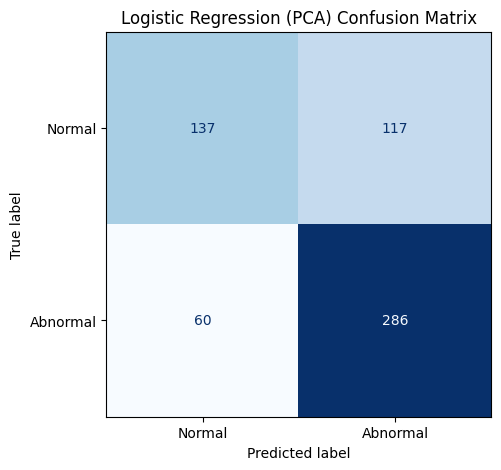

In [49]:
# 1. Initialize
lr_model = LogisticRegression(max_iter=1000, random_state=SEED)

# 2. Train (on PCA Features)
print("Training Logistic Regression on PCA Features...")
lr_model.fit(Xf_train, y_train_bin)

# 3. Predict
y_pred_lr = lr_model.predict(Xf_test)

# 4. Evaluate
res_lr = evaluate_model("Logistic Regression (PCA)", y_test_bin, y_pred_lr)

## Random Forest Training and Evaluation

Training Random Forest on PCA Features...

EVALUATION: Random Forest (PCA)
Accuracy:  0.7483
Precision: 0.7586
Recall:    0.8266
F1 Score:  0.7911
--------------------
Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.64      0.68       254
    Abnormal       0.76      0.83      0.79       346

    accuracy                           0.75       600
   macro avg       0.74      0.73      0.74       600
weighted avg       0.75      0.75      0.75       600



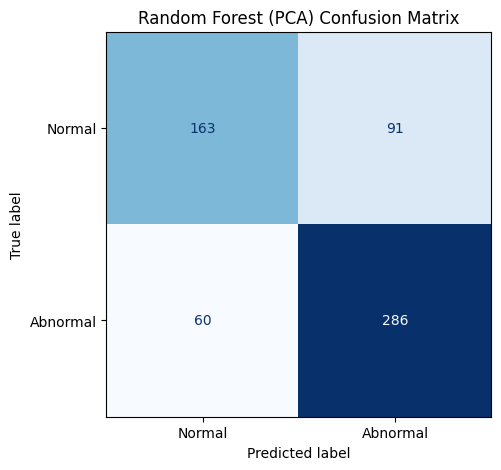

In [46]:
# 1. Initialize
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)

# 2. Train (on PCA Features)
print("Training Random Forest on PCA Features...")
rf_model.fit(Xf_train, y_train_bin)

# 3. Predict
y_pred_rf = rf_model.predict(Xf_test)

# 4. Evaluate
res_rf = evaluate_model("Random Forest (PCA)", y_test_bin, y_pred_rf)

## CNN Training and Evaluation


TRAINING CNN (DEEPER + BATCH NORM)
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7341 - loss: 0.5237 - val_accuracy: 0.7817 - val_loss: 0.4773 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8150 - loss: 0.4194 - val_accuracy: 0.8233 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8328 - loss: 0.3888 - val_accuracy: 0.8267 - val_loss: 0.4062 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8333 - loss: 0.3830 - val_accuracy: 0.8483 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8390 - loss: 0.3624 - val_accuracy: 0.7733 - val_loss: 0.4776 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8431 - loss: 0.3577 - val_accuracy: 0.8283 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accurac

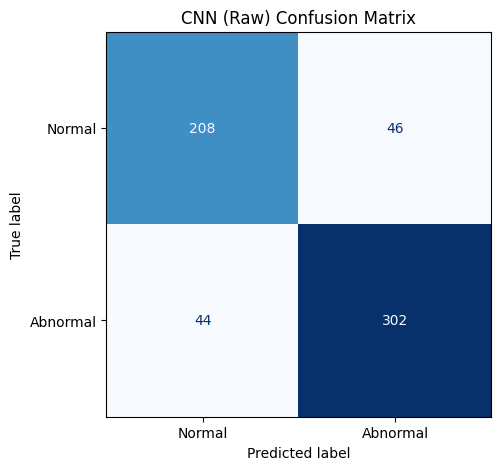

In [53]:
# 1. Define Architecture
def build_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # --- Block 1: The "Spike Detector" (Low-level features) ---
    model.add(Conv1D(filters=32, kernel_size=10, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    # --- Block 2: The "Wave Detector" (Mid-level features) ---
    model.add(Conv1D(filters=64, kernel_size=10, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    # --- Block 3: The "Complex Shape Detector" (High-level features) ---
    # This layer sees the relationship between P, QRS, and T
    model.add(Conv1D(filters=128, kernel_size=10, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    # --- Block 4: Optional Deep Feature Extraction ---
    model.add(Conv1D(filters=256, kernel_size=10, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # Global Average Pooling replaces Flatten (Reduces parameters, prevents overfitting)
    model.add(GlobalAveragePooling1D())

    # --- Classifier Head ---
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) # Standard dropout to force robustness
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid')) # Binary Output

    # Compile
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2. Setup Callbacks (The "Smart Teacher")
callbacks = [
    # If validation loss doesn't improve for 5 epochs, stop training.
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),

    # If validation loss gets stuck for 3 epochs, slow down learning rate by 50%.
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
]

# 3. Build & Train
print(f"\n{'='*40}")
print("TRAINING CNN (DEEPER + BATCH NORM)")
print(f"{'='*40}")

cnn = build_cnn((5000, 12))

history_ = cnn.fit(
    X_train, y_train_bin,
    validation_data=(X_test, y_test_bin),
    epochs=50,          # Increased from 10 to 50
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 4. Evaluate
# Predict probabilities -> threshold at 0.5 -> 0 or 1
y_pred_prob = cnn.predict(X_test)
y_pred_cnn = (y_pred_prob > 0.5).astype(int).flatten()

res_cnn = evaluate_model("CNN (Raw)", y_test_bin, y_pred_cnn)

## Final Result Of All Models

In [54]:
results_df = pd.DataFrame([res_lr,res_rf,res_cnn])

results_df.style.format({
    'accuracy': '{:.2%}',
    'precision': '{:.2%}',
    'recall': '{:.2%}',
    'f1 score': '{:.2%}'
})

,model,accuracy,precision,recall,f1 score
0,Logistic Regression (PCA),70.50%,70.97%,82.66%,76.37%
1,Random Forest (PCA),74.83%,75.86%,82.66%,79.11%
2,CNN (Raw),85.00%,86.78%,87.28%,87.03%


# 📌 Conclusion

We trained and compared **three models** for MI detection:

### ✔ Logistic Regression (very fast, uses simple features)  
### ✔ Random Forest (better than LR in many cases)  
### ✔ 1D CNN (uses raw ECG, learns automatically)

Evaluation metrics included:
- Accuracy  
- Precision  
- Recall  
- F1  
- Confusion Matrix  